In [1]:
import pandas as pd
from openpyxl import load_workbook
import numpy as np

In [2]:
def getMostRecentData(self, columns, unwanted):
    """
    Checks the columns in reverse order, taking the value from the right-most column which doesn't contain the unwanted value.
    Returns two columns, one of which contains the most recent value and the other of which contains the the year that value happened.
    """
    result = self.loc[:,:]
    
    def checkNumber(obs, new, colOrVal):
        if obs[new] == unwanted and obs[col] != '..':
            if colOrVal == 'val':
                return obs[col]
            elif colOrVal == 'col':
                return col[:4]
        else:
            return obs[new]
    
    result['recentValue'] = unwanted
    result['recentYear'] = unwanted
    for col in columns[::-1]:
        result['recentValue'] = result.apply(lambda x: checkNumber(x, 'recentValue', 'val'), axis = 1)
        result['recentYear'] = result.apply(lambda x: checkNumber(x, 'recentYear', 'col'), axis = 1)
    return result    


pd.DataFrame.getMostRecentData = getMostRecentData

In [19]:
files = !ls
files

['Archive',
 'Child Mortality.html',
 'Child poverty data (1).ipynb',
 'ChildMortality.csv',
 'DeathRates.xlsx',
 'FemaleLifeExp.json',
 'FemaleLifeExpectancy.csv',
 'LADMFLifeExp.json',
 'LifeExpectancy.xlsx',
 'Link TopoJson to ONS Secondary Source.ipynb',
 'MaleFemale LifeExp.html',
 'MaleLifeExp.json',
 'MaleLifeExpectancy.csv',
 'Social Grade.xls',
 'femaleRegions.json',
 'headlineData.json',
 'lad.json',
 'local_child_poverty_basket_of_indicators.xlsx',
 'maleRegions.json',
 'regionalData.json',
 'topo_lad.json',
 'topo_ladall.json',
 'topo_lgd.json',
 'topo_reg.json',
 'uk.json']

In [4]:
wb = load_workbook("local_child_poverty_basket_of_indicators.xlsx")

/Users/richardmuir/anaconda/lib/python3.5/site-packages/openpyxl/workbook/names/named_range.py:124: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


Show a D3/carto map of the uk with the different boundaries drawn in and coloured based on the 'badness' of infant mortality/life expectancy(m/f). We can then show which other country is most similar to that particular place. When the user clicks on the boundary area, the Plotly charts change to show a scatterplot matrix of that variable against all the explanatory variables with that boundary's data point highlighted.

We can then show time series charts of the explanatory variables, grouping as such: (Employment rate, 'Employment rate (male)', 'Employment rate (female)'), (obese_reception, underweight_reception), then singles.

Potential explanatory variables:
- %of children in workless households
- low income families
- overall employment rate
- average earnings pw
- affordable housing
- obese reception
- underweight reception

Response variables:
- infant_mortality
- life expectancy
- FSMgap at KS4


UK boundary data: http://statistics.data.gov.uk/doc/statistical-geography/E06000001

In [5]:
explanatoryVariables = ['Workless households_children', 
                        'Employment rate',
                        'Employment rate (male)',
                        'Employment rate (female)',
                       'average_earnings',
                       'FSM GAP KS4',
                       'Affordable_housing',
                         'obese_reception',
                         'underweight_reception',
                        'Young offenders',
                       'Low Birth Weight',]

responseVariables = ['Life expectancy_m',
                     'Life expectancy_f',
                    'Infant_mortality',]

In [6]:
explan = {}
for var in explanatoryVariables:
    if var == "FSM GAP KS4":
        skip = 2
    else: skip = 3
    print(var)
    df = pd.read_excel("local_child_poverty_basket_of_indicators.xlsx", sheetname = var, skiprows=3)
    #df.drop(['Old Boundary ID'] + [i for i in df.columns if 'Unnamed' in str(i)], axis = 1, inplace = True)
    explan[var] = df

Workless households_children
Employment rate
Employment rate (male)
Employment rate (female)
average_earnings
FSM GAP KS4
Affordable_housing
obese_reception
underweight_reception
Young offenders
Low Birth Weight


## todo below:

In [7]:
response = {}
for var in responseVariables:
    df = pd.read_excel("local_child_poverty_basket_of_indicators.xlsx", sheetname = var, skiprows=3)
    #df.drop(['Old Boundary ID'] + [i for i in df.columns if 'Unnamed' in str(i)], axis = 1, inplace = True)
    df.rename(columns={'Latest data' : 'LatestData'}, inplace = True)
    df.dropna(axis = 0, how='all', subset=["LatestData"], inplace = True)
    
    #this drops all the rows where latestData - '-' - for some of these rows, there is previous data which I need to agglomerate
    # into latest data - do this before publish
    df.query("LatestData != '-'", inplace = True)
    df.query("LatestData != '..'", inplace = True)
    df.reset_index(drop=True, inplace = True)
    response[var] = df

In [12]:
response['Infant_mortality'].head()

,Boundary ID,Old Boundary ID,Boundary Name,LatestData,2010,2011,2012
0,E06000001,00EB,Hartlepool,2.6,5.3,3.4,2.6
1,E06000002,00EC,Middlesbrough,2.9,4.2,4.5,2.9
2,E06000003,00EE,Redcar and Cleveland,3.1,5,-,3.1
3,E06000004,00EF,Stockton-on-Tees,3.7,3.6,4.9,3.7
4,E06000005,00EH,Darlington,2.9,2.9,4.6,2.9


# fix for fsm gap ks4

In [8]:
## really fricking annoying; doesn't work in the loop
explan['FSM GAP KS4'] = pd.read_excel("local_child_poverty_basket_of_indicators.xlsx", sheetname = var, skiprows=3)
explan['FSM GAP KS4'].head()

,Boundary ID,Old Boundary ID,Boundary Name,Latest data,2010,2011,2012
0,E06000001,00EB,Hartlepool,2.6,5.3,3.4,2.6
1,E06000002,00EC,Middlesbrough,2.9,4.2,4.5,2.9
2,E06000003,00EE,Redcar and Cleveland,3.1,5,-,3.1
3,E06000004,00EF,Stockton-on-Tees,3.7,3.6,4.9,3.7
4,E06000005,00EH,Darlington,2.9,2.9,4.6,2.9


## checks geo codes

In [13]:
response['Infant_mortality'][response['Infant_mortality']['Boundary ID'] == 'E06000002']
                                                              

,Boundary ID,Old Boundary ID,Boundary Name,LatestData,2010,2011,2012
1,E06000002,00EC,Middlesbrough,2.9,4.2,4.5,2.9


# Getting the comparison countries for Child mortality and life expectancy

In [20]:
files

['Archive',
 'Child Mortality.html',
 'Child poverty data (1).ipynb',
 'ChildMortality.csv',
 'DeathRates.xlsx',
 'FemaleLifeExp.json',
 'FemaleLifeExpectancy.csv',
 'LADMFLifeExp.json',
 'LifeExpectancy.xlsx',
 'Link TopoJson to ONS Secondary Source.ipynb',
 'MaleFemale LifeExp.html',
 'MaleLifeExp.json',
 'MaleLifeExpectancy.csv',
 'Social Grade.xls',
 'femaleRegions.json',
 'headlineData.json',
 'lad.json',
 'local_child_poverty_basket_of_indicators.xlsx',
 'maleRegions.json',
 'regionalData.json',
 'topo_lad.json',
 'topo_ladall.json',
 'topo_lgd.json',
 'topo_reg.json',
 'uk.json']

In [26]:
#reads in the data in .csv
files = ! ls
globalIndics = {f : pd.read_csv(f) for f in files if '.csv' in f}
for k, v in globalIndics.items():
    v.dropna(axis = 1, how = 'all', inplace = True)    
    v = v.getMostRecentData([c for c in v.columns if '[YR' in c], '..')
    v.drop(['Series Name','Series Code'] + [c for c in v.columns if '[YR' in c], axis = 1, inplace = True)
    v.query("recentValue != '..'", inplace = True)
    v['recentValue'] = pd.to_numeric(v['recentValue'])
    v.reset_index(drop=True, inplace = True)


In [27]:
def compareCountries(source, ukData, globalData):
    #print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
    #print(source)
    result = ukData.loc[:,:]
    comparisonCountries = []
    comparisonCountryRate = []
    LAD = []
    LADScore = []
    for i in range(len(ukData)):
        #print(ukData.loc[i,'Boundary Name'])
        comparisonCountries.append(globalData['Country Name'][(globalData['recentValue'] - ukData.loc[i,'LatestData']).abs().argsort()[0]])
        comparisonCountryRate.append(globalData['recentValue'][(globalData['recentValue'] - ukData.loc[i,'LatestData']).abs().argsort()[0]])
        LAD.append(ukData.loc[i,'Boundary Name'])
        LADScore.append(ukData.loc[i,'LatestData'])
        
    result['comparisonCountry'] = comparisonCountries
    result['comparisonCountryRate'] = comparisonCountryRate
    result['LADCheck'] = LAD
    result['LADscoreCheck'] = LADScore
    return result
        

In [29]:
#brings together the UK and global DataFrames
finalIndicators = {'ChildMortality' : {'globalData' : globalIndics['ChildMortality.csv'],
                                      'UKData' : response['Infant_mortality']},
                   
                  'MaleLifeExpectancy' : {'globalData' : globalIndics['MaleLifeExpectancy.csv'],
                                      'UKData' : response['Life expectancy_m']},
                   
                  'FemaleLifeExpectancy' : {'globalData' : globalIndics['FemaleLifeExpectancy.csv'],
                                      'UKData' : response['Life expectancy_f']}}

In [30]:
for indicator, sources in finalIndicators.items():
    sources['combined'] = compareCountries(indicator, sources['UKData'], sources['globalData'])
    sources['combined'].drop([c for c in sources['combined'].columns if c not in ['Boundary ID','Boundary Name','LatestData',
                                                                                 'comparisonCountry', 'comparisonCountryRate']],
                             axis = 1, inplace = True)
    sources['combined'].to_json('{}.json'.format(indicator), orient='records')


In [136]:
#list(finalIndicators['ChildMortality']['combined']['Boundary ID'])
finalIndicators['ChildMortality']['combined']

,Boundary ID,Boundary Name,LatestData,comparisonCountry,comparisonCountryRate
0,E06000001,Hartlepool,2.6,San Marino,2.6
1,E06000002,Middlesbrough,2.9,Denmark,2.9
2,E06000003,Redcar and Cleveland,3.1,Germany,3.1
3,E06000004,Stockton-on-Tees,3.7,Greece,3.6
4,E06000005,Darlington,2.9,Denmark,2.9
5,E06000006,Halton,2.4,Sweden,2.4
6,E06000007,Warrington,4.8,"Macedonia, FYR",4.8
7,E06000008,Blackburn with Darwen,4.3,Canada,4.3
8,E06000009,Blackpool,3.4,Switzerland,3.4
9,E06000010,"Kingston upon Hull, City of",3.6,Greece,3.6


## Add in the social class data

In [33]:
! ls

Archive
Child Mortality.html
Child poverty data (1).ipynb
ChildMortality.csv
ChildMortality.json
DeathRates.xlsx
FemaleLifeExp.json
FemaleLifeExpectancy.csv
FemaleLifeExpectancy.json
LADMFLifeExp.json
LifeExpectancy.xlsx
Link TopoJson to ONS Secondary Source.ipynb
MaleFemale LifeExp.html
MaleLifeExp.json
MaleLifeExpectancy.csv
MaleLifeExpectancy.json
Social Grade.xls
femaleRegions.json
headlineData.json
lad.json
local_child_poverty_basket_of_indicators.xlsx
maleRegions.json
regionalData.json
topo_lad.json
topo_ladall.json
topo_lgd.json
topo_reg.json
uk.json


In [72]:
import xlrd
import numpy as np

In [64]:
wb = xlrd.open_workbook('Social Grade.xls')
wb.sheet_names()

['Information',
 'QS611EW_Numbers',
 'QS611EW_Percentages',
 'QS611EW_Ranks',
 'Metadata']

In [161]:
def combineColumns(row, cols):
    if pd.notnull(row[cols[0]]):
        val = row[cols[0]]
    else:
        val = row[cols[1]]
    return val

In [162]:
grade = pd.read_excel('Social Grade.xls',
                      sheetname='QS611EW_Percentages',
                      skiprows=10
                    ).drop(['Area name','All categories: Approximated social grade'], axis = 1,
                          ).rename(columns={'Unnamed: 2' : 'Area name', 'Area code' : 'Area Code'})

grade['Area Name'] = grade.apply(combineColumns, args=(['Area name', 'Unnamed: 3'],), axis=1)
grade['Area Code'] = grade['Area Code'].astype(str)
grade['E'] = grade['Area Code'].apply(lambda x: x[:3])
grade = grade[grade['E'].isin(['E06','E07','E08','E09'])]
grade = grade[['Area Code','Area Name','Approximated social grade AB', 'Approximated social grade C1',
       'Approximated social grade C2', 'Approximated social grade DE']]#grade.drop(['Area name','Unnamed: 3'], axis = 1, inplace = True)


grade.head(5)

,Area Code,Area Name,Approximated social grade AB,Approximated social grade C1,Approximated social grade C2,Approximated social grade DE
9,E06000047,County Durham UA,16.3,28.4,23,32.4
10,E06000005,Darlington UA,18.2,30.3,22,29.5
11,E06000001,Hartlepool UA,12.7,25.6,23.8,37.8
12,E06000002,Middlesbrough UA,11.5,26.6,21,40.9
13,E06000048,Northumberland UA,19.4,29.7,23.4,27.4


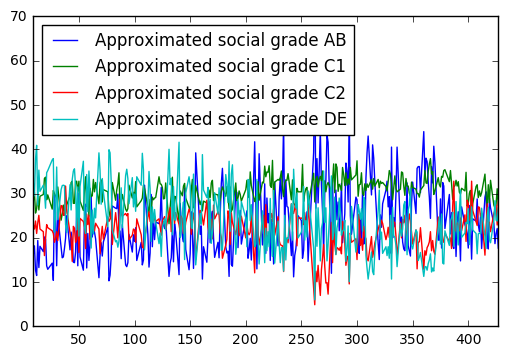

In [163]:
%matplotlib inline
grade.plot()

## Merging onto child mortality

In [169]:
finalIndicators['MaleLifeExpectancy']['combined'].describe()

,comparisonCountryRate
count,160.000000
mean,78.910294
std,1.429612
min,73.963000
25%,77.974000
50%,78.990000
75%,80.021000
max,81.200000


In [165]:
merge1 = pd.merge(finalIndicators['ChildMortality']['combined'], 
                  grade,
                  how='outer',
                  right_on='Area Code',
                  left_on='Boundary ID')
merge1

,Boundary ID,Boundary Name,LatestData,comparisonCountry,comparisonCountryRate,Area Code,Area Name,Approximated social grade AB,Approximated social grade C1,Approximated social grade C2,Approximated social grade DE
0,E06000001,Hartlepool,2.6,San Marino,2.6,E06000001,Hartlepool UA,12.7,25.6,23.8,37.8
1,E06000002,Middlesbrough,2.9,Denmark,2.9,E06000002,Middlesbrough UA,11.5,26.6,21,40.9
2,E06000003,Redcar and Cleveland,3.1,Germany,3.1,E06000003,Redcar and Cleveland UA,13.3,26.3,25.1,35.3
3,E06000004,Stockton-on-Tees,3.7,Greece,3.6,E06000004,Stockton-on-Tees UA,18.1,29.4,22,30.5
4,E06000005,Darlington,2.9,Denmark,2.9,E06000005,Darlington UA,18.2,30.3,22,29.5
5,E06000006,Halton,2.4,Sweden,2.4,E06000006,Halton UA,13.7,28.9,21.4,36
6,E06000007,Warrington,4.8,"Macedonia, FYR",4.8,E06000007,Warrington UA,25,31.5,19.4,24.1
7,E06000008,Blackburn with Darwen,4.3,Canada,4.3,E06000008,Blackburn with Darwen UA,14.3,26.5,21.6,37.6
8,E06000009,Blackpool,3.4,Switzerland,3.4,E06000009,Blackpool UA,10.4,30.7,21,37.9
9,E06000010,"Kingston upon Hull, City of",3.6,Greece,3.6,E06000010,"Kingston upon Hull, City of UA",10.3,26.2,23.7,39.9


In [168]:
notLeft = merge1[merge1['Boundary ID'].isnull()]
notLeft

,Boundary ID,Boundary Name,LatestData,comparisonCountry,comparisonCountryRate,Area Code,Area Name,Approximated social grade AB,Approximated social grade C1,Approximated social grade C2,Approximated social grade DE
154,NaN,NaN,NaN,NaN,NaN,E07000026,Allerdale,17.8,24,27.3,30.9
155,NaN,NaN,NaN,NaN,NaN,E07000027,Barrow-in-Furness,15.5,25.4,27.2,31.8
156,NaN,NaN,NaN,NaN,NaN,E07000028,Carlisle,15.7,27.4,25.1,31.9
157,NaN,NaN,NaN,NaN,NaN,E07000029,Copeland,17.6,25.5,25.1,31.8
158,NaN,NaN,NaN,NaN,NaN,E07000030,Eden,19.9,25.4,31.7,23
159,NaN,NaN,NaN,NaN,NaN,E07000031,South Lakeland,25,27.4,26.5,21.2
160,NaN,NaN,NaN,NaN,NaN,E07000117,Burnley,12.7,26.2,23.7,37.3
161,NaN,NaN,NaN,NaN,NaN,E07000118,Chorley,24.2,30.8,22.4,22.6
162,NaN,NaN,NaN,NaN,NaN,E07000119,Fylde,27.6,33.8,17.6,21
163,NaN,NaN,NaN,NaN,NaN,E07000120,Hyndburn,13.2,27.1,25.4,34.3


### Geo
It seems that the E06, E08 and E09 are all sibling subdivisions with the region (E12) as a parent. I'll need to plot all of these on the same chart to confirm or deny this.

In [ ]:
code3[code3['Boundary ID'].apply(lambda x: str(x)[:3]) == 'E10']

In [ ]:
import requests
response = requests.get("https://raw.githubusercontent.com/martinjc/UK-GeoJSON/master/json/administrative/eng/lad.json")
geo = response.json()

In [ ]:
import json
with open("ukgeodata.json", 'w') as outfile:
    json.dump(geo, outfile)

In [ ]:
len(geo['features'])

In [ ]:
for i, ftr in enumerate(geo['features']):
    if ftr['properties']['LAD13CD'][:3] == "E07":
        print(ftr['properties']['LAD13NM'])
        del geo['features'][i]

In [ ]:
len(geo['features'])

In [ ]:
import json
with open("ukgeodataNOE07.json", 'w') as outfile:
    json.dump(geo, outfile)